![example](images/director_shot.jpeg)

# Determining Optimal Attributes for a Movie Release

**Authors:** Cameron T Ladd, Ji Hoon Chung
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

1. What is the most profitable kind of movie by genre?
2. What is the optimal runtime of each movie per genre?
3. What season is the best time to release per genre?

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

## IMPORT MODULES

In [9]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

In [10]:
# Examine data folder contents
# !ls data/zippedData

## IMPORT ALL DATA

In [11]:
#Box Office Mojo Data (bom)
bom_moviegross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

#IMDB Data (imdb)
imdb_title_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz')

#The Numbers (tn)
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

## PREVIEW DataFrames IN USE

In [12]:
# bom_moviegross_df.head()

In [13]:
# imdb_title_basics_df.head()

In [14]:
# tn_movie_budgets_df.head()

## Preliminary check for missing values

In [15]:
# bom_moviegross_df.isna().sum()

In [16]:
# imdb_title_basics_df.isna().sum()

In [17]:
# tn_movie_budgets_df.isna().sum()

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Box Office Mojo Data

In [18]:
# bom_moviegross_df.info()

In [19]:
# bom_moviegross_df['foreign_gross'].describe()

In [20]:
# bom_moviegross_df.isna().sum()

In [21]:
# bom_moviegross_df['foreign_gross'].shape

In [22]:
# Find percentage of null values to determine dataset viability
num_missing_bom_foreigngross = bom_moviegross_df.isna().sum()['foreign_gross']
total_moviegross_entries = len(bom_moviegross_df['foreign_gross'])
percentage_missing_foreign = num_missing_bom_foreigngross / total_moviegross_entries
print(percentage_missing_foreign)

0.3985828166519043


In [23]:
print(len(list(bom_moviegross_df['foreign_gross'].unique())))
non_standard = []
for x in list(bom_moviegross_df['foreign_gross'].unique()):
    if type(x) != int and type(x) != float:
        non_standard.append(x)
    else:
        pass

1205


In [24]:
# Find length of new non-standard list so we know how many of the uniques are floats or ints (just one)
print(len(non_standard))
# Find out if any of the unique values AREN'T strings
[type(x) for x in non_standard if type(x) != str]

1204


[]

Let's summarize what we have so far:
    
    3387 total entries
    1350 null values
    1204 str type values

This leaves:
    
    833 int/float type values

In [25]:
# Converted from str, int, float to exclusively float
foreign_gross_numeric = pd.to_numeric(bom_moviegross_df['foreign_gross'], errors = 'coerce', downcast = 'float') 
# Assigned new series in place of original df series
bom_moviegross_df['foreign_gross'] = foreign_gross_numeric
# bom_moviegross_df['foreign_gross'].describe()

In [26]:
# Adjust the dataset by filling NaN values with the mean (filling it with the median changed the dataset's descriptive statistics much too drastically)
foreign_gross_mean = bom_moviegross_df['foreign_gross'].mean()
mean_adjusted = bom_moviegross_df['foreign_gross'].fillna(foreign_gross_mean)
# Remove all entries with domestic or foreign gross less than 1,000,000, since this is a large company we are concerned with
mean_adjusted_removed = bom_moviegross_df[(bom_moviegross_df['foreign_gross'] > 1000000) & (bom_moviegross_df['domestic_gross'] > 1000000)]
# mean_adjusted.describe()

In [27]:
# Remove entries that don't have a domestic gross value, since it only constitutes a small portion of the data
mean_adjusted_removed.dropna(axis=0, how='any', inplace=True)
# Drop columns that will not be used
mean_adjusted_removed.drop('year', axis=1, inplace=True)
mean_adjusted_removed.drop('studio', axis=1, inplace=True)

<ipython-input-27-fcbb0c5d7930>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_adjusted_removed.dropna(axis=0, how='any', inplace=True)
/Users/jihoon/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [28]:
# Assign the cleaned dataframe a new index and variable
final_moviegross_df = mean_adjusted_removed.set_index('title')
final_moviegross_df['total_gross'] = final_moviegross_df['domestic_gross'] + final_moviegross_df['foreign_gross']

In [29]:
# final_moviegross_df

## IMDB Title_basics data

Let's clean the imdb_title_basics_df

In [30]:
# imdb_title_basics_df

In [31]:
# Set index to primary_title for merging later
imdb_title_index = imdb_title_basics_df.set_index('primary_title')
# Drop unused columns
imdb_title_index_dropped = imdb_title_index.drop(['tconst', 'original_title', 'start_year'], axis=1)
# Drop entries that have missing values (there are very few and we need all values for our analysis)
imdb_title_index_removedna = imdb_title_index_dropped.dropna(axis=0, how = 'any')
# Assign cleaned DataFrame to new variable
final_imdb_title_df = imdb_title_index_removedna

Here are the two DataFrames we have so far:

In [32]:
# final_imdb_title_df

In [33]:
# final_moviegross_df

## tn_movie_budgets_df

In [34]:
# Stripping dollar signs from the series
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].map(lambda x: x.lstrip('$'))
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].map(lambda x: x.lstrip('$'))
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].map(lambda x: x.lstrip('$'))
# Remove the commas from the series
tn_movie_budgets_df.loc[:, "production_budget":"worldwide_gross"] = tn_movie_budgets_df.loc[:, "production_budget":"worldwide_gross"].replace(",","", regex=True).astype('int64')
# Rename the columns
tn_movie_budgets_df.rename(columns = {'movie':"primary_title"}, inplace = True)
final_imdb_title_df.rename(columns = {'primary_title':"title"}, inplace = True)

/Users/jihoon/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## Merging the data

In [35]:
# Perform inner merge
final_df = tn_movie_budgets_df.merge(final_imdb_title_df, on= 'primary_title', how= 'inner')
# Create a total_gross column for further understanding of the data
final_df["total_gross"] = final_df["domestic_gross"] + final_df["worldwide_gross"]

In [36]:
# final_df

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

comment on my code

## Average Gross per Genre

In [37]:
# Stack the genres columns after removing the columns (must set expand=True so that it returns a DataFrame rather thana series)
# Count the total occurences of each genre
count = final_df['genres'].str.split(',', expand=True).stack().value_counts()
# Copy final_df to another variable
genres = final_df.copy()

In [38]:
# Split genres into columns
genres[['genre1', 'genre2', 'genre3']] = final_df['genres'].str.split(',', expand=True)
# Calculate profit per movie
genres['profit'] = genres['total_gross'] - genres['production_budget']
# genres

In [39]:
# Find total world_wide, domestic_ gross, and total_gross for each genre across all entries

# Worldwide
genre1_worldwide_gross = genres.groupby('genre1')['worldwide_gross'].sum()
genre2_worldwide_gross = genres.groupby('genre2')['worldwide_gross'].sum()
genre3_worldwide_gross = genres.groupby('genre3')['worldwide_gross'].sum()
# Domestic
genre1_domestic_gross = genres.groupby('genre1')['domestic_gross'].sum()
genre2_domestic_gross = genres.groupby('genre2')['domestic_gross'].sum()
genre3_domestic_gross = genres.groupby('genre3')['domestic_gross'].sum()
# Total
genre1_total_gross = genres.groupby('genre1')['total_gross'].sum()
genre2_total_gross = genres.groupby('genre2')['total_gross'].sum()
genre3_total_gross = genres.groupby('genre3')['total_gross'].sum()

# Add the calculated values and drop insignificant genres

# Worldwide
genre_total_worldwide_gross = genre1_worldwide_gross.add(genre2_worldwide_gross, fill_value=0).add(genre3_worldwide_gross, fill_value=0)
final_genre_worldwide_gross = genre_total_worldwide_gross.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# Domestic
genre_total_domestic_gross = genre1_domestic_gross.add(genre2_domestic_gross, fill_value=0).add(genre3_domestic_gross, fill_value=0)
final_genre_total_domestic_growth = genre_total_domestic_gross.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# Total
genre_total_gross = genre1_total_gross.add(genre2_total_gross, fill_value=0).add(genre3_total_gross, fill_value=0)
final_genre_total_gross = genre_total_gross.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])

In [40]:
#Concatenate series into a useable DataFrame, rename index
final_gross_df = pd.concat([final_genre_total_domestic_growth, final_genre_worldwide_gross, final_genre_total_gross], axis=1).reset_index()
final_gross_df_cleaned = final_gross_df.set_index('index')
final_gross_df_cleaned.index.name = 'Genre'

In [51]:
count

Drama          1641
Comedy          793
Action          647
Thriller        544
Adventure       469
Documentary     452
Horror          381
Crime           379
Romance         350
Biography       247
Mystery         233
Sci-Fi          212
Family          189
Fantasy         184
Animation       137
History          90
Music            84
Sport            70
War              48
Musical          28
Western          18
News              7
Reality-TV        1
dtype: int64

<AxesSubplot:>

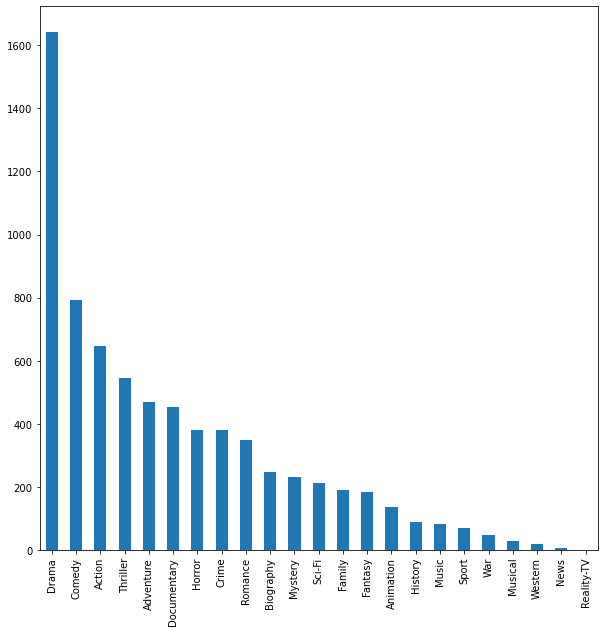

In [47]:
# Plot count of each genre to determine the top 8
count.plot(kind='bar', figsize=(10,10))

The top 8 genres by occurence will be the genres of focus for our analysis. These include Drama, Comedy, Action, Thriller, Adventure, Documentary, Horror, Crime

In [43]:
# Concatenate the count series to the final_gross_df_cleaned DataFrame to calculate averages
final_gross_avg = pd.concat([final_gross_df_cleaned, count], axis=1)
# Clean up DataFrame
final_gross_avg.rename(columns = {0:'count'}, inplace=True)
final_gross_avg.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'], inplace=True)
# Calculate averages
final_gross_avg['domestic_avg'] = final_gross_avg['domestic_gross'] / final_gross_avg['count']
final_gross_avg['worldwide_avg'] = final_gross_avg['worldwide_gross'] / final_gross_avg['count']
final_gross_avg['total_avg'] = final_gross_avg['total_gross'] / final_gross_avg['count']
# Drop unneeded columns for easier plotting
final_gross_avg.drop(['domestic_gross', 'worldwide_gross', 'total_gross', 'count', 'total_avg'], axis=1, inplace=True)

Text(0, 0.5, 'Average Gross(in $100 million)')

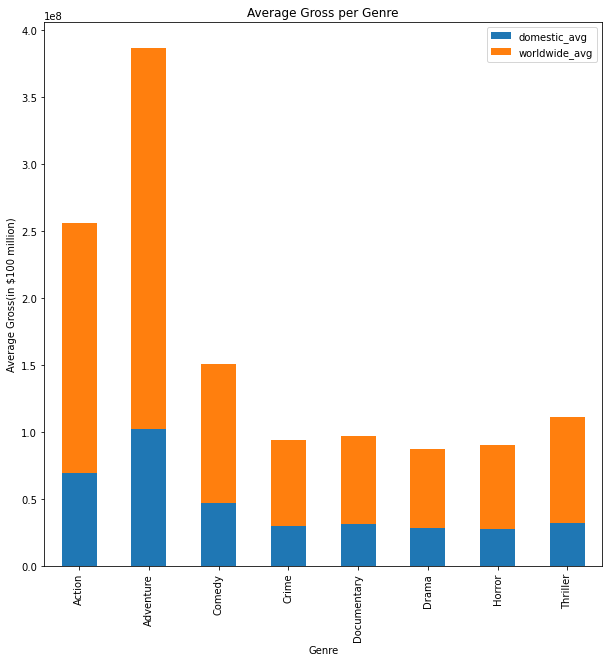

In [44]:
# Plot data
final_gross_avg.plot(kind='bar', stacked=True, figsize=(10,10))
plt.title('Average Gross per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Gross(in $100 million)')

These two visualization of both total gross revenue per genre and average gross revenue per genre provide very useful insights:

1. Adventure is the has the highest grossing average out of the top 8 movies based on occurence. 

2. When looking at the 'Adventure' genre, we see that it performs markedly better worldwide than domestically

Using these insights, we can conclude that Microsoft should focus on releasing a movie from the 'Adventure' genre, while also taking preliminary action towards advertisement and the securing of movie distribution rights in international countries of interest. This will encourage greater success for the release.

## Average Profit per Genre

In [45]:
# Final total profit (Gross - Budget) for each genre
genre1_total_profit = genres.groupby('genre1')['profit'].sum()
genre2_total_profit = genres.groupby('genre2')['profit'].sum()
genre3_total_profit = genres.groupby('genre3')['profit'].sum()
# Sum up calculated values and drop insignificant genres
genre_overall_profit = genre1_total_profit.add(genre2_total_profit, fill_value=0).add(genre3_total_profit, fill_value=0)
final_genre_profit_df = genre_overall_profit.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# final_genre_profit_df

# Concatenate the two series(count and final_genre_profit_df) to create a DataFrame organized by index
merged = pd.concat([final_genre_profit_df, count], axis=1)
# Rename the column's
final_merged = merged.rename(columns={0:'count'})
# Calculate average profit
final_merged['average_profit'] = final_merged['profit'] / final_merged['count']
# Drop insignificant rows (insignificant due to low amount of entries)
averages = final_merged.drop(['News', 'Reality-TV', 'Romance', 'Biography', 'Mystery', 'Sci-Fi', 'Family', 'Fantasy', 'Animation', 'History', 'Music', 'Sport', 'War', 'Musical', 'Western'])
# Drop previously used catergories for easier plotting
averages_without_profit = averages.drop(['profit', 'count'], axis=1)

Text(0, 0.5, 'Profit (in $100 millions)')

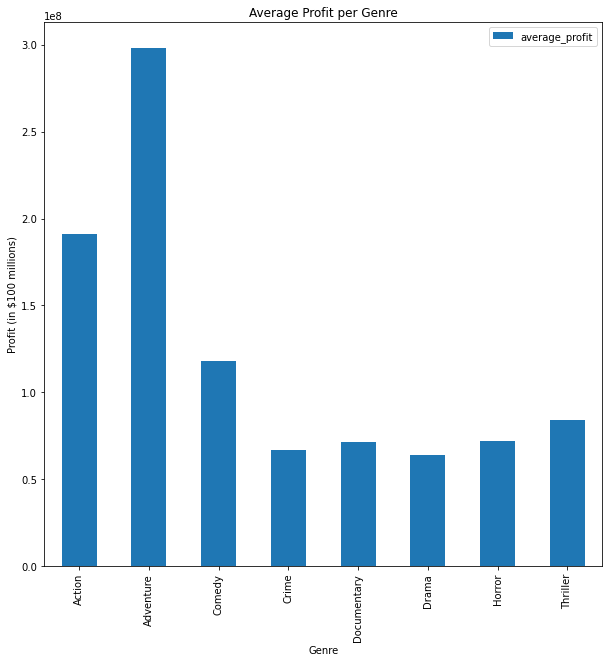

In [46]:
# Plot data
averages_without_profit.plot(kind='bar', figsize=(10,10))
plt.title('Average Profit per Genre')
plt.xlabel('Genre')
plt.ylabel('Profit (in $100 millions)')

This profit distribution is solely here to show that average profit is directly correlated to average gross, and therefore the average gross visualization is more insightful due to its further exploration into the extra variables of 'domestic gross' and 'worldwide gross'.

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***